In [ ]:
! pip install segmentation_models_pytorch

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch, os, cv2, numpy as np
import matplotlib.pyplot as plt
from glob import glob
from torchvision import transforms as T
import albumentations as A
from PIL import Image
import gdown, cv2
import segmentation_models_pytorch as smp

In [ ]:

%load_ext autoreload
%autoreload 2

def get_data(path, ds_name = "Cardiac_Catheterization"):


    if os.path.isdir(path): print(" Data is here"); pass

    # if pretrain file has not been dawnloaded yet

    else:
        os.makedirs(path, exist_ok=True)
        Url = "https://drive.google.com/file/d/1a_OZ6-BpMQi01NIkm4l54EzyMTzLNJGU/view?usp=sharing" if ds_name == "Cardiac_Catheterization" else None


        # get data ID

        data_id =  Url.split("/")[-2]

        # set prefix
        prefix = "https://drive.google.com/uc?/export=download&id="

        # Dawnload and checkpoint

        gdown.download(prefix+data_id, path, quiet=False)
        folder_names = glob(f"{path}/*")
#         folder_names = glob(f"{path}/*")
        print(folder_names)

        for folder_name in folder_names:

            os.system(f"unzip {folder_name} -d {path} ")
            os.remove(folder_name)

get_data(path="data_Cardiac", ds_name = "Cardiac_Catheterization")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Downloading...
From: https://drive.google.com/uc?/export=download&id=1a_OZ6-BpMQi01NIkm4l54EzyMTzLNJGU
To: /content/data_Cardiac
100%|██████████| 230M/230M [00:02<00:00, 104MB/s] 


['data_Cardiac/data_Cardiac0e7hla_itmp']


In [ ]:
def get_transformation(size):
    return [A.Compose([A.Resize(size, size),
                     A.HorizontalFlip(0.5),
                     A.GaussNoise(0.3),
                     A.VerticalFlip(0.5)], is_check_shapes=False),
            A.Compose([A.Resize(size, size)], is_check_shapes=False)]

tr_tr, ts_tr = get_transformation(size = 320)
tr_tr, ts_tr

(Compose([
   Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
   HorizontalFlip(always_apply=0.5, p=0.5),
   GaussNoise(always_apply=False, p=0.5, var_limit=(0, 0.3), per_channel=True, mean=0),
   VerticalFlip(always_apply=0.5, p=0.5),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=False),
 Compose([
   Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=False))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root, transformations = None, im_files = [".png", ".jpg", ".jepg"]):
        super(). __init__()
        self.transformations =transformations
        self.tensorsize = T.Compose([T.ToTensor()])

#         self.im_path = sorted(glob(f"{root}/*/images/*"[{im for im in im_file}]))
#         self.gt_path = sorted(glob(f"{root}/*/images/*"[{im for im in im_file}]))

        self.im_path = sorted(glob(f"{root}/images/*[{im_file for im_file in im_files}]"))
        self.gt_path = sorted(glob(f"{root}/masks/*[{im_file for im_file in im_files}]"))
#         print(len(self.im_path))

    def __len__(self): return len(self.im_path)

    def __getitem__(self, idx):

#         try: cv2.cvtColor(cv2.imread(self.im_path[idx]), cv2.COLOR_BGR2RGB)
#         except: print(self.im_path[idx])

        im = cv2.cvtColor(cv2.imread(self.im_path[idx]), cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor(cv2.imread(self.gt_path[idx]), cv2.COLOR_BGR2GRAY)

#         print(idx)

        if self.transformations is not None:
            tr_ed = self.transformations(image = im , mask = gt)
            im = tr_ed['image']
            gt = tr_ed['mask']

        im = self.tensorsize(im)
        gt = torch.tensor(gt>128).long()


        return im, gt
data ="data_Cardiac/Cardiac_Catheterization/train"

ds = CustomDataset(root= data, transformations=ts_tr)
ds[5]
# print(ds[2][1].shape)

(tensor([[[0.3804, 0.3804, 0.3843,  ..., 0.4275, 0.4314, 0.4078],
          [0.4039, 0.3843, 0.4157,  ..., 0.4392, 0.4471, 0.4196],
          [0.3804, 0.4000, 0.4000,  ..., 0.4549, 0.4588, 0.4196],
          ...,
          [0.2196, 0.2235, 0.1843,  ..., 0.6314, 0.6078, 0.5843],
          [0.2235, 0.2314, 0.2314,  ..., 0.6157, 0.5804, 0.5529],
          [0.2157, 0.1961, 0.1804,  ..., 0.6392, 0.6000, 0.5843]],
 
         [[0.3804, 0.3804, 0.3843,  ..., 0.4275, 0.4314, 0.4078],
          [0.4039, 0.3843, 0.4157,  ..., 0.4392, 0.4471, 0.4196],
          [0.3804, 0.4000, 0.4000,  ..., 0.4549, 0.4588, 0.4196],
          ...,
          [0.2196, 0.2235, 0.1843,  ..., 0.6314, 0.6078, 0.5843],
          [0.2235, 0.2314, 0.2314,  ..., 0.6157, 0.5804, 0.5529],
          [0.2157, 0.1961, 0.1804,  ..., 0.6392, 0.6000, 0.5843]],
 
         [[0.3804, 0.3804, 0.3843,  ..., 0.4275, 0.4314, 0.4078],
          [0.4039, 0.3843, 0.4157,  ..., 0.4392, 0.4471, 0.4196],
          [0.3804, 0.4000, 0.4000,  ...,

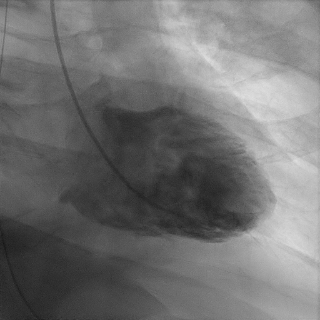

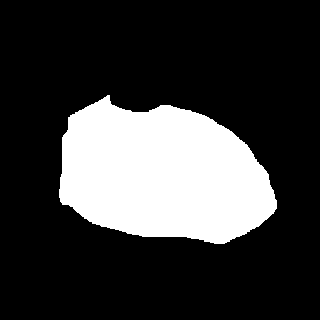

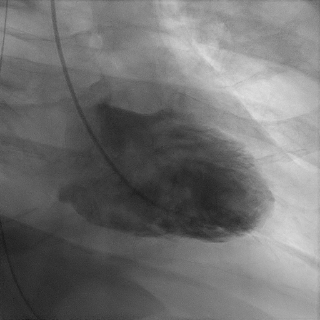

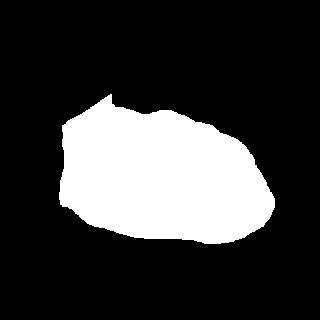

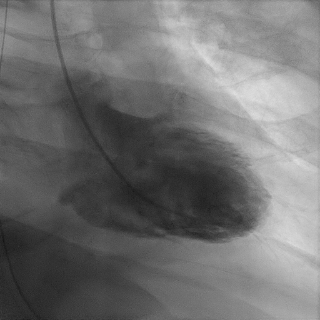

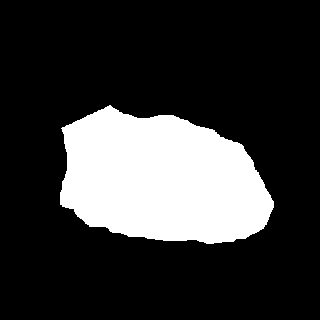

In [ ]:
import numpy as np
def tn_2_np(t):
     return (t*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if len(t)==3 else (t*255).detach().cpu().numpy().astype(np.uint8)

for idx, data in enumerate(ds):
    if idx ==3: break

    im, gt =data
    display(Image.fromarray(tn_2_np(im)))
    display(Image.fromarray(tn_2_np(gt)))

In [ ]:
def get_dls(root, transformations, bs,  split = [0.8, 0.1, 0.1]):

    ds = CustomDataset(root=root, transformations=transformations)
    tr_length = len(ds)

#     print(tr_length)
    tr_len = int(split[0]*tr_length)
    vl_len = int(split[1]*tr_length)
    test_len = tr_length - tr_len - vl_len

    tr_ds, val_ds, ts_ds = random_split(ds, [tr_len, vl_len, test_len ])

    print(f"Number of train dataset data         => {len(tr_ds)}")
    print(f"Number of validation dataset data    => {len(val_ds)}")
    print(f"Number of test dataset data          => {len(ts_ds)}")

    tr_dlr = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=0)
    val_dlr = DataLoader(tr_ds, batch_size=bs, shuffle=False, num_workers=0)
    ts_dlr = DataLoader(tr_ds, batch_size=1, shuffle=False, num_workers=0)

    return tr_dlr, val_dlr, ts_dlr

tr_dlr, val_dlr, ts_dlr  = get_dls(root="data_Cardiac/Cardiac_Catheterization/train", transformations= ts_tr, bs=16)


Number of train dataset data         => 1373
Number of validation dataset data    => 171
Number of test dataset data          => 173


In [ ]:
model = smp.Unet(encoder_name='resnet18', classes=2, encoder_depth = 5,
                encoder_weights = 'imagenet', activation=None, decoder_channels = [256, 128, 64, 32, 16])
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
# device = "cude" if torch.cuda.is_available else 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from tqdm import tqdm

class Metrics():
    def __init__(self, pred, gt, loss_fn, eps = 3e-4, num_class = 2):

        self.pred = torch.argmax(torch.nn.functional.softmax(pred, dim = 1), dim =1)

        self.gt = gt
        self.loss_fn = loss_fn
        self.pred_ = pred
        self.eps =eps
        self.num_class =num_class

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    #PA

    def PA(self):
        with torch.no_grad():

            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum())/float(match.numel())

    #mIoU

    def mIoU(self):
        pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

        IoU_number_class = []

        for a in range(self.num_class):
            match_pred = pred == a
            match_gt =gt == a


            # print("\nmatch_pred size:", match_pred.size())
            # print("\nmatch_gt size:", match_gt.size())

            if match_gt.long().sum().item()==0: IoU_number_class.append(np.nan)
            else:
                intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                union = torch.logical_or(match_pred, match_gt).sum().float().item()



                iou = (intersection)/(union+self.eps)

                IoU_number_class.append(iou)

            return np.nanmean(IoU_number_class)

        # loss function
    def loss(self):


      return self.loss_fn(self.pred_, self.gt)






In [ ]:
def train(model, tr_dlr, val_dlr, epochs, device, loss_fn, opt, save_prefix):

    tr_loss, tr_pa, tr_iou= [],[],[]
    val_loss, val_pa, val_iou = [],[],[]
    tr_len, val_len = len(tr_dlr), len(val_dlr)


    best_loss = np.inf
    decrease, not_improve, early_stop_threshold =1,0,6
    os.makedirs("save_file", exist_ok=True)

    model.to(device)

    print("Train is starting .......")

    for epoch in range(1, epochs+1):

        tr_loss_, tr_pa_, tr_iou_ = 0,0,0
        model.train()

        print(f"{epoch}- epoch training")
        for idx, batch in enumerate(tqdm(tr_dlr)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)


            pred = model(im)
            met = Metrics(pred, gt, loss_fn)


            loss_ =met.loss()

            tr_iou_+=met.mIoU()
            tr_pa_+=met.PA()
            tr_loss_+=loss_.item()

            opt.zero_grad()
            loss_.backward()
            opt.step()

        print(f"{epoch} - epoch validation starting")

        model.eval()
        val_loss_, val_pa_, val_iou_ = 0,0,0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dlr)):

                im, gt = batch
                im, gt = im.to(device), gt.to(device)

                pred = model(im)

                met = Metrics(pred, gt, loss_fn)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()

        print(f"{epoch}- epoch train finished")

        tr_iou_/= tr_len
        tr_loss_/=tr_len
        tr_pa_/=tr_len

        val_iou_/=val_len
        val_loss_/=val_len
        val_pa_/= val_len

        print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"{epoch}- epoch train result:\n")
        print(f"Train loss                 --> {tr_loss_:.3f}")
        print(f"Train PA                   --> {tr_pa_:.3f}")
        print(f"Train mIoU                 --> {tr_iou_:.3f}")

        print(f"Validation loss             --> {val_loss_:.3f}")
        print(f"Validation PA               --> {val_pa_:.3f}")
        print(f"Validation mIoU             --> {val_iou_:.3f}")


        tr_loss.append(tr_loss_)
        tr_pa.append(tr_pa_)
        tr_iou.append(tr_iou_)

        val_loss.append(val_loss_)
        val_pa.append(val_pa_)
        val_iou.append(val_iou_)


        if val_loss_ < best_loss:
            not_improve +=1
            decrease +=1
            best_loss = val_loss_

            if decrease % 2 ==0:
                print(f"The model with the lowest error is saved")
                torch.save(model, f"save_file/{save_prefix}_best_model.pt")


        if val_loss_ > best_loss:
            not_improve+=1

            best_loss = val_loss_

            print(f"Xatolik {not_improve} epoch davomida kamaygani yo'q!")

            if not_improve == early_stop_threshold:
                print(f"Xatolik {early_stop_threshold} epoch davomida kamaymagani uchun train jarayonini to'xtatamiz!")
                break
        print("---------------------------------------------------")

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, 'tr_pa': tr_pa,
           "val_loss": val_loss, "val_iou": val_iou, 'val_pa': val_pa}


In [ ]:
results = train(model = model, tr_dlr=tr_dlr, val_dlr=val_dlr, epochs=10,
               device=device, loss_fn=loss_fn, opt=optimizer, save_prefix="save_file")


Train is starting .......
1- epoch training


100%|██████████| 86/86 [00:28<00:00,  2.99it/s]


1 - epoch validation starting


100%|██████████| 86/86 [00:19<00:00,  4.39it/s]


1- epoch train finished

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1- epoch train result:

Train loss                 --> 0.133
Train PA                   --> 0.952
Train mIoU                 --> 0.944
Validation loss             --> 0.049
Validation PA               --> 0.982
Validation mIoU             --> 0.978
The model with the lowest error is saved
---------------------------------------------------
2- epoch training


100%|██████████| 86/86 [00:23<00:00,  3.71it/s]


2 - epoch validation starting


100%|██████████| 86/86 [00:26<00:00,  3.23it/s]


2- epoch train finished

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2- epoch train result:

Train loss                 --> 0.043
Train PA                   --> 0.983
Train mIoU                 --> 0.981
Validation loss             --> 0.035
Validation PA               --> 0.986
Validation mIoU             --> 0.984
---------------------------------------------------
3- epoch training


100%|██████████| 86/86 [00:22<00:00,  3.80it/s]


3 - epoch validation starting


100%|██████████| 86/86 [00:18<00:00,  4.65it/s]


3- epoch train finished

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3- epoch train result:

Train loss                 --> 0.035
Train PA                   --> 0.986
Train mIoU                 --> 0.984
Validation loss             --> 0.033
Validation PA               --> 0.986
Validation mIoU             --> 0.984
The model with the lowest error is saved
---------------------------------------------------
4- epoch training


100%|██████████| 86/86 [00:23<00:00,  3.69it/s]


4 - epoch validation starting


100%|██████████| 86/86 [00:19<00:00,  4.31it/s]


4- epoch train finished

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4- epoch train result:

Train loss                 --> 0.031
Train PA                   --> 0.987
Train mIoU                 --> 0.985
Validation loss             --> 0.029
Validation PA               --> 0.988
Validation mIoU             --> 0.986
---------------------------------------------------
5- epoch training


100%|██████████| 86/86 [00:22<00:00,  3.75it/s]


5 - epoch validation starting


100%|██████████| 86/86 [00:19<00:00,  4.48it/s]


5- epoch train finished

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5- epoch train result:

Train loss                 --> 0.028
Train PA                   --> 0.988
Train mIoU                 --> 0.986
Validation loss             --> 0.026
Validation PA               --> 0.989
Validation mIoU             --> 0.987
The model with the lowest error is saved
---------------------------------------------------
6- epoch training


100%|██████████| 86/86 [00:23<00:00,  3.71it/s]


6 - epoch validation starting


100%|██████████| 86/86 [00:18<00:00,  4.59it/s]


6- epoch train finished

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
6- epoch train result:

Train loss                 --> 0.027
Train PA                   --> 0.989
Train mIoU                 --> 0.987
Validation loss             --> 0.024
Validation PA               --> 0.990
Validation mIoU             --> 0.988
---------------------------------------------------
7- epoch training


100%|██████████| 86/86 [00:23<00:00,  3.73it/s]


7 - epoch validation starting


100%|██████████| 86/86 [00:20<00:00,  4.29it/s]


7- epoch train finished

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
7- epoch train result:

Train loss                 --> 0.025
Train PA                   --> 0.989
Train mIoU                 --> 0.987
Validation loss             --> 0.027
Validation PA               --> 0.989
Validation mIoU             --> 0.987
Xatolik 7 epoch davomida kamaygani yo'q!
---------------------------------------------------
8- epoch training


100%|██████████| 86/86 [00:23<00:00,  3.68it/s]


8 - epoch validation starting


100%|██████████| 86/86 [00:22<00:00,  3.89it/s]


8- epoch train finished

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
8- epoch train result:

Train loss                 --> 0.024
Train PA                   --> 0.990
Train mIoU                 --> 0.988
Validation loss             --> 0.026
Validation PA               --> 0.989
Validation mIoU             --> 0.987
The model with the lowest error is saved
---------------------------------------------------
9- epoch training


100%|██████████| 86/86 [00:23<00:00,  3.60it/s]


9 - epoch validation starting


100%|██████████| 86/86 [00:19<00:00,  4.45it/s]


9- epoch train finished

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
9- epoch train result:

Train loss                 --> 0.023
Train PA                   --> 0.990
Train mIoU                 --> 0.988
Validation loss             --> 0.022
Validation PA               --> 0.990
Validation mIoU             --> 0.989
---------------------------------------------------
10- epoch training


100%|██████████| 86/86 [00:23<00:00,  3.69it/s]


10 - epoch validation starting


100%|██████████| 86/86 [00:19<00:00,  4.50it/s]


10- epoch train finished

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
10- epoch train result:

Train loss                 --> 0.022
Train PA                   --> 0.991
Train mIoU                 --> 0.989
Validation loss             --> 0.020
Validation PA               --> 0.992
Validation mIoU             --> 0.990
The model with the lowest error is saved
---------------------------------------------------


In [ ]:
results

{'tr_loss': [0.133205640324673,
  0.04329357917832081,
  0.03490330164082522,
  0.03112017653535965,
  0.02841296482311432,
  0.02726202676895746,
  0.0254693737816672,
  0.024349587124794028,
  0.023415652493578056,
  0.021768690931589105],
 'tr_iou': [0.9441793730297002,
  0.9805012065458993,
  0.9835333251558991,
  0.985062381544471,
  0.9861952115379345,
  0.9865945689708402,
  0.9874071677113253,
  0.9878758209194415,
  0.9882980136550548,
  0.9890999893660413],
 'tr_pa': [0.9515138924313785,
  0.9833779836255453,
  0.9859862506027087,
  0.9873008070179726,
  0.9882726679547743,
  0.9886131010925624,
  0.9893076735276443,
  0.9897058760586706,
  0.9900706129807694,
  0.9907558598117459],
 'val_loss': [0.04913092006084531,
  0.03506305094721705,
  0.03303894056223853,
  0.02930384874343872,
  0.02626836787216192,
  0.02420726392504781,
  0.026774264460559503,
  0.026333830817494283,
  0.022435522421674674,
  0.019898363031706837],
 'val_iou': [0.978466097118072,
  0.983616419988354

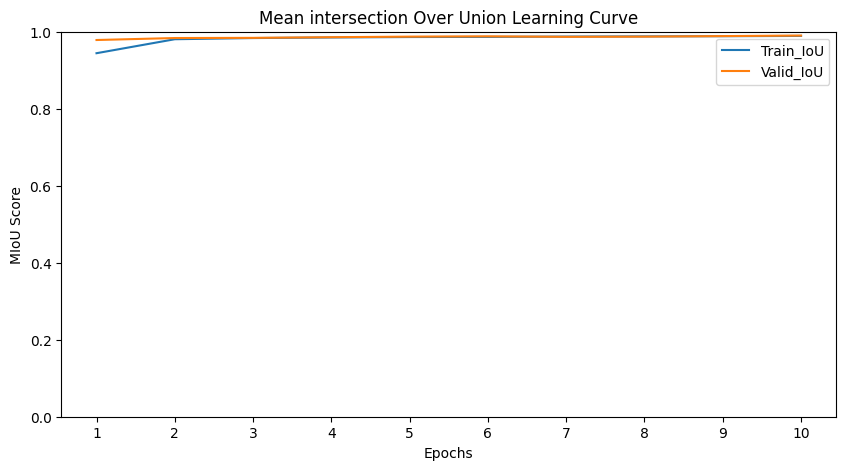

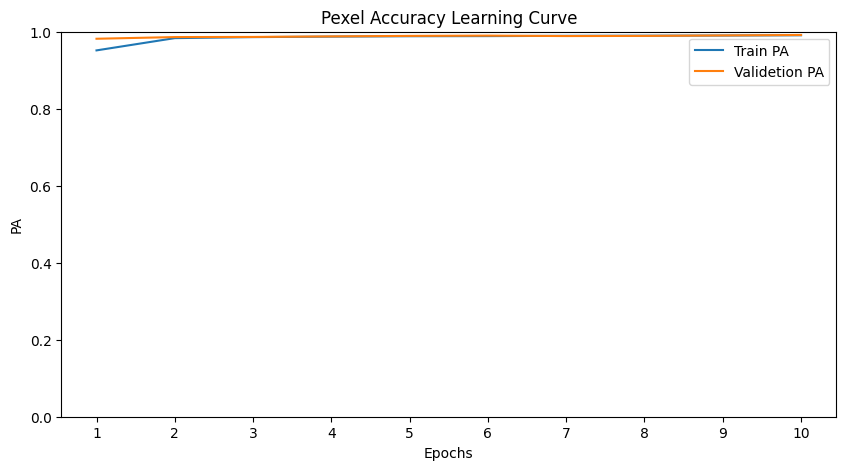

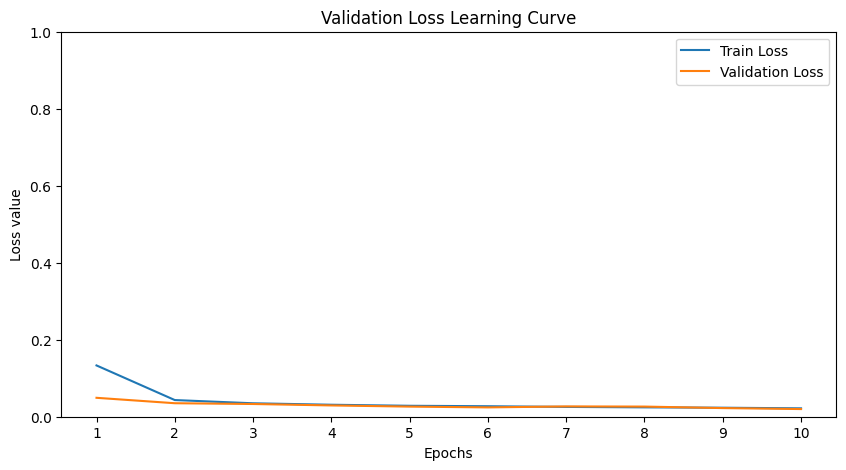

In [ ]:
import matplotlib.pyplot as plt

class Plot():
    def __init__(self, res):


        plt.figure(figsize =(10,5))
        plt.plot(res['tr_iou'], label = 'Train_IoU')
        plt.plot(res['val_iou'], label = 'Valid_IoU')
        plt.title("Mean intersection Over Union Learning Curve")
        plt.xlabel('Epochs')
        plt.xticks(np.arange(len(res['val_iou'])), [i for i in range(1, len(res['val_iou']) + 1)])
        plt.ylabel('MIoU Score')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()

        plt.figure(figsize = (10, 5))
        plt.plot(res['tr_pa'], label = "Train PA")
        plt.plot(res['val_pa'], label = "Validetion PA")
        plt.title("Pexel Accuracy Learning Curve")
        plt.xlabel('Epochs')
        plt.xticks(np.arange(len(res['val_pa'])), [i for i in range(1, len(res['val_pa']) + 1)])
        plt.ylabel("PA")
        plt.ylim(0, 1)
        plt.legend()
        plt.show()

        plt.figure(figsize = (10, 5))
        plt.plot(res['tr_loss'], label = "Train Loss")
        plt.plot(res['val_loss'], label = "Validation Loss")
        plt.title("Validation Loss Learning Curve")
        plt.xlabel('Epochs')
        plt.xticks(np.arange(len(res['val_loss'])), [i for i in range(1, len(res['val_loss']) + 1)])


        plt.ylabel("Loss value")
        plt.ylim(0, 1)
        plt.legend()
        plt.show()
Plot(results)




In [ ]:
def inference(dl, model, device):
  count =1
  for idx, batch in enumerate(dl):
    if idx==2: break
    im, gt =batch

    pred = model(im.to(device))

    plt.figure(figsize= (10, 5))
    plt.subplot(2, 3, count)
    plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off")
    plt.title("Orginal")

    count+=1

    plt.subplot(2,3, count)
    plt.imshow(gt.squeeze(0), cmap = "gray")
    plt.title("Ground Truth")
    plt.axis("off")
    count+=1

    plt.subplot(2, 3, count)
    plt.imshow(tn_2_np((pred >0.5).squeeze(0))[1], cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()
    count += 1



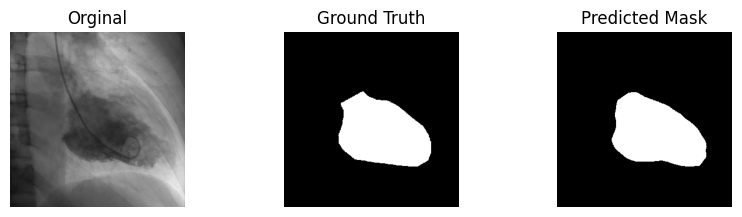

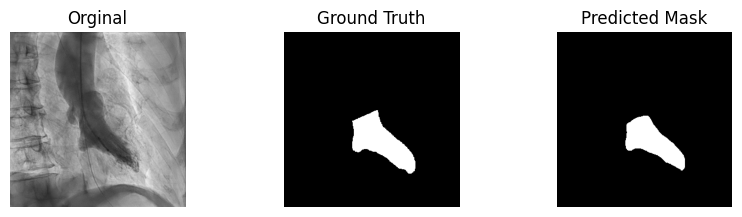

In [ ]:
model = torch.load("save_file/save_file_best_model.pt")
inference( ts_dlr, model = model, device = device)